## SkyScan Audit - Airplane Classifier

Detect passenger jets from SkyScan images

In [3]:
################################################
##
## Object Detection
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

#######################################################

from fastai.vision.all import *


#######################################################

N_EPOCHS = 10000          ## 4000
batch_size = 10   ## 5    ## 32
learning_rate =  0.1    ## 0.01   ## 1e-5 

learning_rate_mse        = 0.0005
learning_rate_pdfcontrol = 0.000001

## probably needs adjustable learning rate scheduler

#######################################################
# define mean and standard deviation of target Gaussian distribution

mean_impulse = 0.
std_impulse  = 0.01

h = 0.03                       # 0.05 >

N_error_range = 20             ## error between pred and real range (-20, 20)

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################

In [12]:

## create directory called fruits with a folder inside for each class (e.g. apple, pepino, etc). 
## Put images in each corresponding folder

path = Path('fruits')


In [13]:
fns = get_image_files(path)
fns

(#1403) [Path('fruits/apple/247_100.jpg'),Path('fruits/apple/257_100.jpg'),Path('fruits/apple/r_78_100.jpg'),Path('fruits/apple/r_68_100.jpg'),Path('fruits/apple/r_150_100.jpg'),Path('fruits/apple/r_140_100.jpg'),Path('fruits/apple/198_100.jpg'),Path('fruits/apple/188_100.jpg'),Path('fruits/apple/18_100.jpg'),Path('fruits/apple/r_132_100.jpg')...]

In [14]:
## This is a data loader

## parent_label -> simply gets the name of the folder a file is in

fruits = DataBlock(
     blocks = (ImageBlock, CategoryBlock),
     get_items = get_image_files,
     splitter = RandomSplitter(valid_pct=0.2, seed=42),
     get_y = parent_label,
     item_tfms = Resize(128)  ## by default it crops
)

In [15]:
dls = fruits.dataloaders(path)

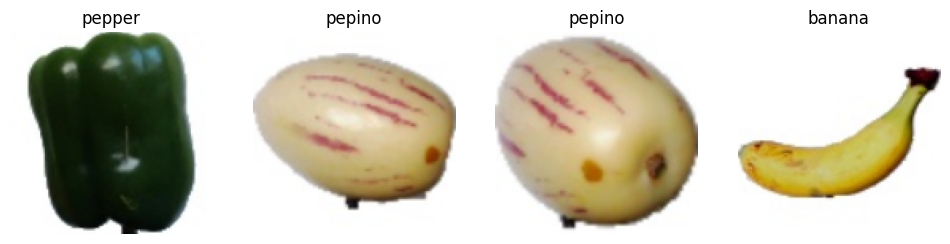

In [16]:
## by defaullt it will give the model batches of 64 for training and testing

## to view

dls.valid.show_batch(max_n=4, nrows=1)

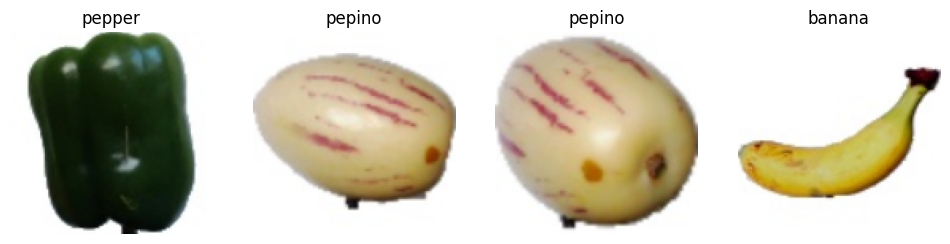

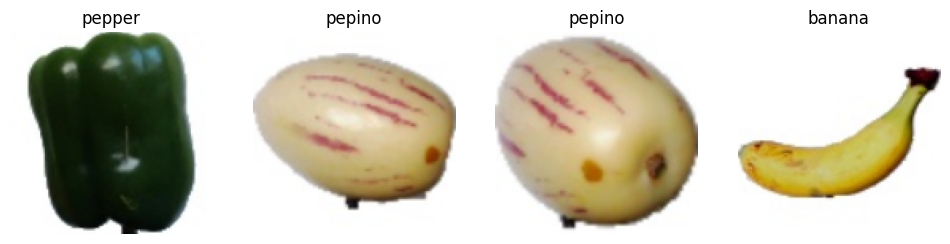

In [17]:
## instead of cropping

## we can pad the images

fruits = fruits.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

## or we can squish them

fruits = fruits.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

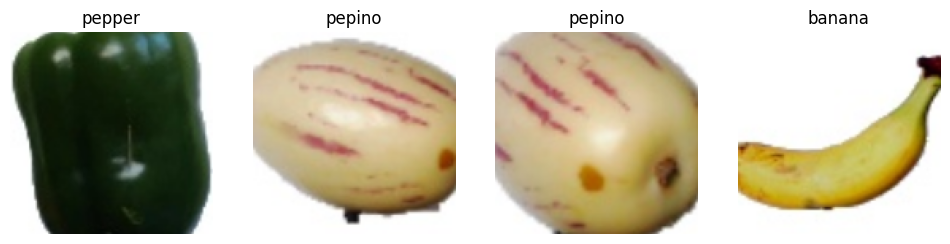

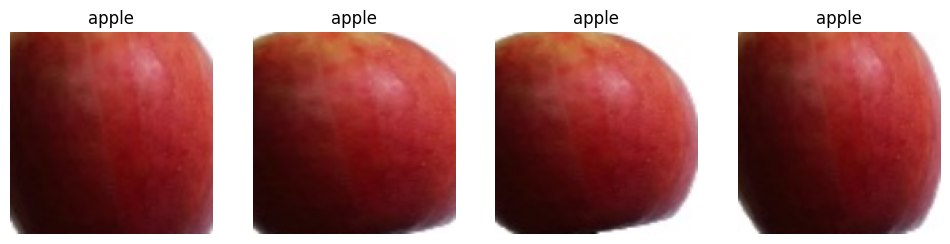

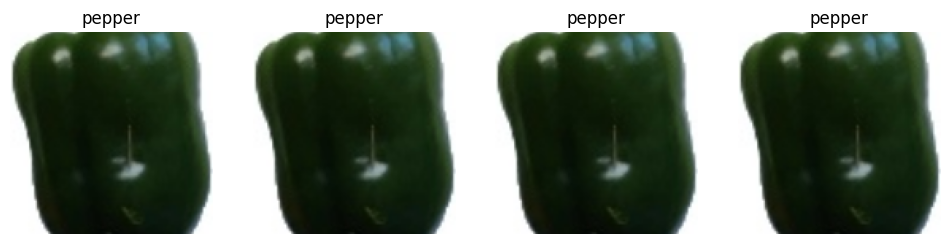

In [18]:
## random cropping of an image is considered better

fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.5))
dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)



fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = fruits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

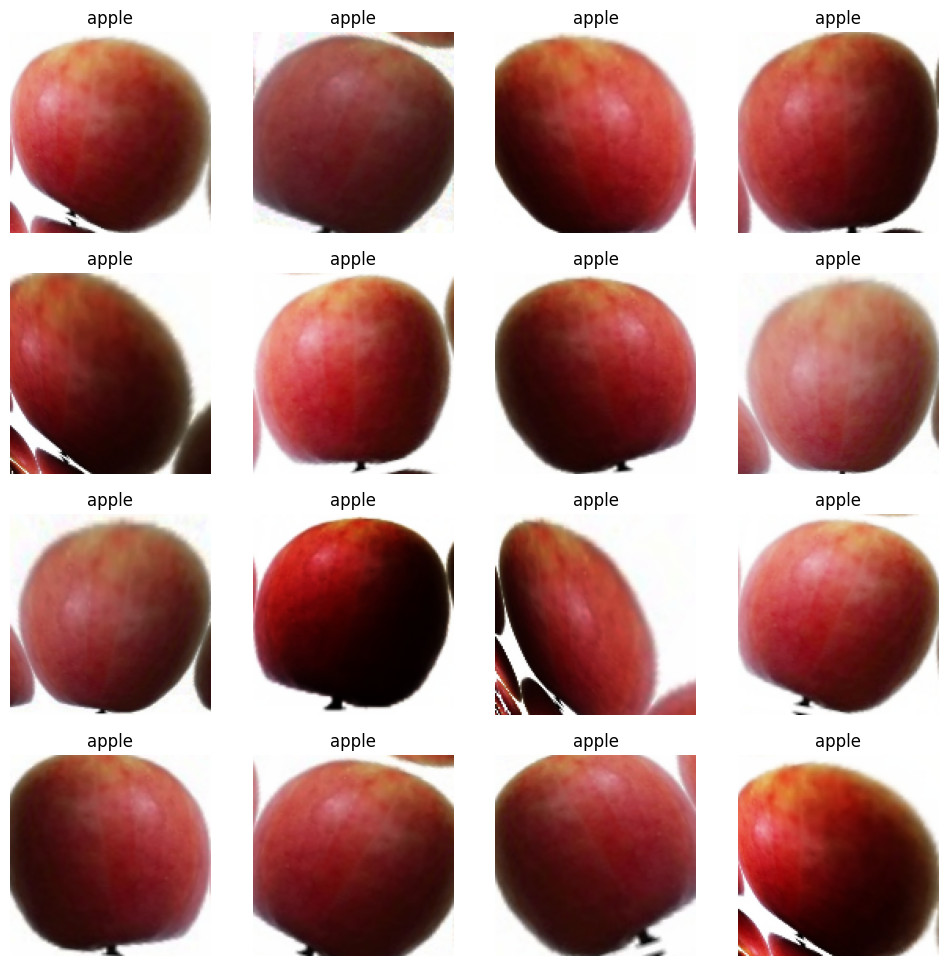

In [21]:
## data augmentation: rotation, flipping, perspective warping, contrast and brightness changes
## via GPU intensive batch_transforms

fruits = fruits.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=16, nrows=4, unique=True)

In [22]:
## now fine tune cnn_learner with our data

fruits = fruits.new(
     item_tfms=RandomResizedCrop(224, min_scale=0.5),
     batch_tfms=aug_transforms()
)

dls = fruits.dataloaders(  path  )

learn = cnn_learner(dls, resnet18, metrics=error_rate)    ## metrics=batch_accuracy, metrics=accuracy

learn.fine_tune(4)

/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/user/opt/anaconda3/envs/SkyScanAudit_py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://downl

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


epoch,train_loss,valid_loss,error_rate,time
0,0.750900,0.000779,0.000000,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.004031,0.000025,0.000000,01:49
1,0.003904,0.000002,0.000000,01:48
2,0.003041,0.000001,0.000000,01:49
3,0.002130,0.000001,0.000000,01:50


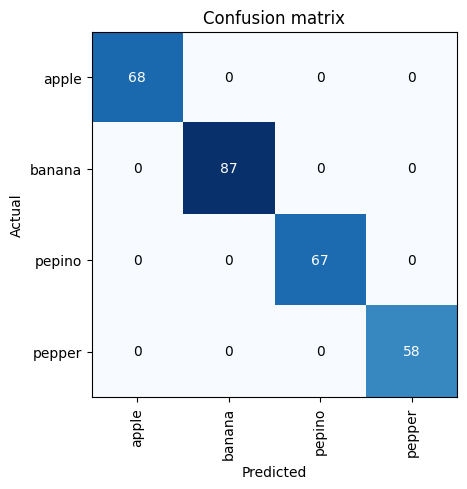

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

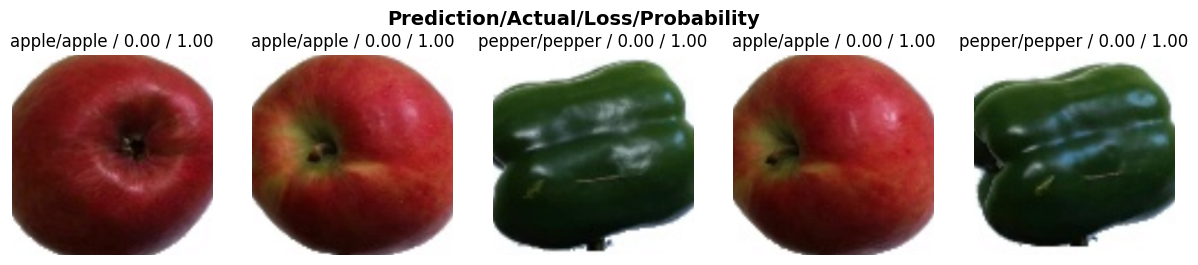

In [24]:
## plot_top_losses shows us the images with the highest loss in our dataset


interp.plot_top_losses(5, nrows=1)

In [25]:
## will save a export file called export.pkl to save the model


learn.export()

In [26]:
## load_model from file


learn_inf = load_learner('export.pkl')



In [27]:

img = 'fruits/apple/r_99_100.jpg'


is_fruit, _, probs = learn.predict(img)
print(is_fruit)
print(probs)


is_fruit, _, probs = learn_inf.predict(img)
print(is_fruit)
print(probs)



apple
TensorBase([    1.0000,     0.0000,     0.0000,     0.0000])


apple
TensorBase([    1.0000,     0.0000,     0.0000,     0.0000])


In [28]:
learn_inf.dls.vocab

['apple', 'banana', 'pepino', 'pepper']

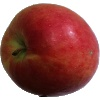

In [29]:

im = Image.open('fruits/apple/r_99_100.jpg')
im.thumbnail((256,256))
im


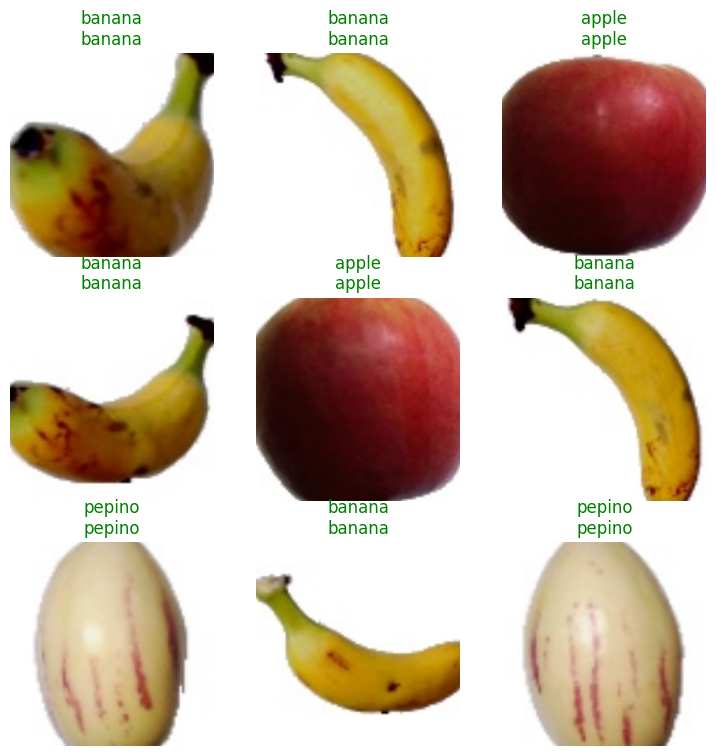

In [30]:
learn.show_results()

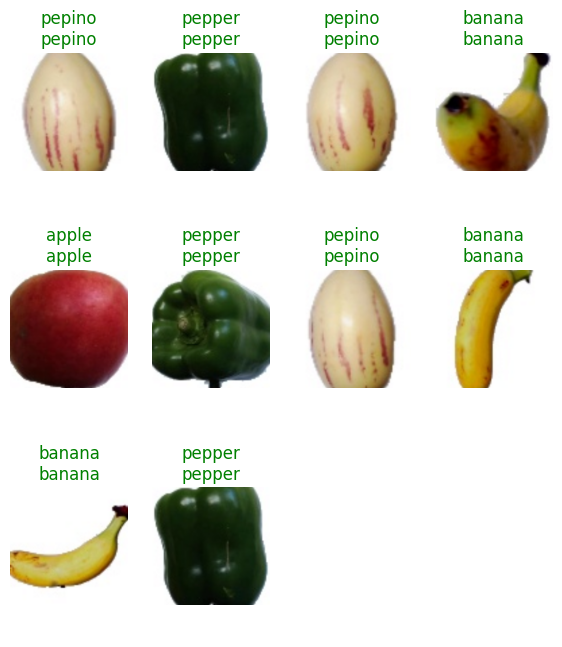

In [31]:
learn.show_results(max_n=10, figsize=(7, 8))